In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score
import random
import math

In [2]:
cols = ['Sex', 'Length', 'Diameter', 
        'Height', 'Whole weight', 'Shucked weight',
        'Viscera weight', 'Shell weight', 'Rings' ]

In [3]:
df = pd.read_csv('./abalone.data', delimiter=",", names=cols)
df.head()
Rings = df['Rings']
df = df.drop(['Rings'], axis = 1)

In [4]:
Rings.head()

0    15
1     7
2     9
3    10
4     7
Name: Rings, dtype: int64

In [5]:
df = pd.get_dummies(df)
cols = df.columns

In [6]:
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0


In [7]:
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=cols)

In [8]:
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
0,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,-0.674834,-0.688018,1.316677
1,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,-0.674834,-0.688018,1.316677
2,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,1.481846,-0.688018,-0.759488
3,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,-0.674834,-0.688018,1.316677
4,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,-0.674834,1.453451,-0.759488


## PCA

In [9]:
n_com = 0
for dim in range(2, df.shape[1]):
    n_com = dim
    pca = PCA(n_components = dim)
    pca.fit(df)
    var_p = pca.explained_variance_ratio_
    if var_p.sum() > 0.95:
        break

pca = PCA(n_components = n_com)
pca.fit(df)
var_p = pca.explained_variance_ratio_
pca_df = pca.transform(df)
print("{} componets preserve {}% of total variance".format(pca_df.shape[1], var_p.sum()))

4 componets preserve 0.9636146712079287% of total variance


In [10]:
pca_df = pd.DataFrame(pca_df)

In [11]:
pca_df.head()

,0,1,2,3
0,-1.442862,-1.523664,-1.151518,-0.412017
1,-2.971084,-1.549403,-1.652189,-0.143979
2,-0.165524,1.484398,-1.147274,0.162377
3,-1.207120,-1.509323,-1.102478,0.190170
4,-4.020928,0.184969,0.558237,-0.243602


## PCA plot

In [12]:
pca_x = pca_df[0].tolist()
pca_y = pca_df[1].tolist()
pca_z = pca_df[2].tolist()

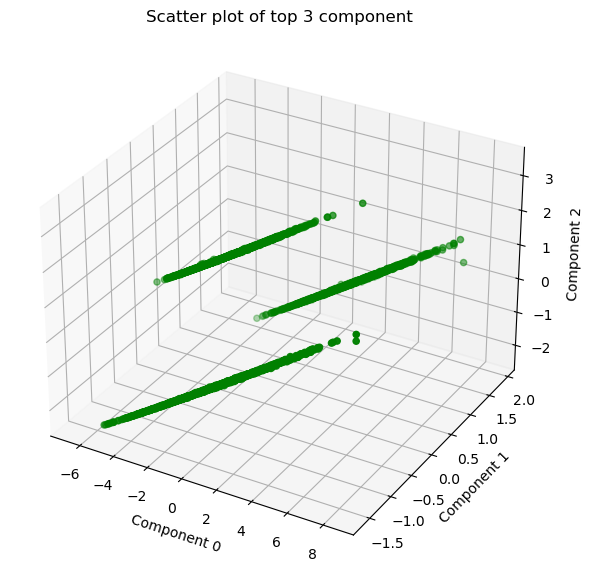

In [13]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(pca_x, pca_y, pca_z, color = "green")
plt.title("Scatter plot of top 3 component")
 
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')

plt.savefig('pca_plot.png')

## K-mean Clustering

In [14]:
# Helper functions


def distance(x1, x2):
    d = 0
    for i in range(len(x1)):
        d += (x1[i] - x2[i])*(x1[i] - x2[i])
    return math.sqrt(d)

def get_new_centeroids(df, clusters, k):
    new_centeroids = [[] for i in range(k)]
    for i in range(len(clusters)):
        
        for j in range(df.shape[1]):
            sum = 0
            for ci in clusters[i]:
                sum += df[j].iloc[ci]
            sum = sum / len(clusters[i])
            new_centeroids[i].append(sum)
    return new_centeroids

def get_new_clusters(df, centeroids, k):
    clusters = [[] for i in range(k)]
    
    for i in range(df.shape[0]):
        min_ = float('inf')
        si = 0
        for ki in range(k):
            d = distance(df.iloc[i].tolist(), centeroids[ki])
            if d < min_:
                min_ = d
                si = ki
        clusters[si].append(i)
    return clusters


def is_converged(centeroids, new_centeroids, tol, k):
    
    min_ = float('inf')
    for i in range(k - 1):
        for j in range(i + 1, k):
            d = distance(centeroids[i], centeroids[j])
            if d < min_:
                min_ = d
       
    
    for i in range(k):
        d = distance(centeroids[i], new_centeroids[i])
        if d > tol*min_:
            return False
    return True
        
    

In [15]:
def kmeans_clustering(df, k, tol):
    centeroids_index = random.sample(range(0, df.shape[0]), k)
    centeroids = []
    for ci in centeroids_index :
        centeroids.append(df.iloc[ci].tolist())
    
    clusters = [[] for i in range(k)]
    
    for i in range(df.shape[0]):
        min_ = float('inf')
        si = 0
        for ki in range(k):
            d = distance(df.iloc[i].tolist(), centeroids[ki])
            if d < min_:
                min_ = d
                si = ki
        clusters[si].append(i)
    
    
    while(1):
        new_centeroids = get_new_centeroids(df, clusters, k)
        if is_converged(centeroids, new_centeroids, tol, k) == True:
            break
        
        new_clusters = get_new_clusters(df, new_centeroids, k)
        
        centeroids = new_centeroids
        clusters = new_clusters
    
    # Geting cluster labels
    
    labels = [-1] * df.shape[0]
    
    for i in range(k):
        cluster = clusters[i]
        for ci in cluster:
            labels[ci] = i
    
    return (labels, centeroids)
            

In [16]:
nmi = []
nmi_n = []
for i in range(2, 9):
    kmeans = cluster.KMeans(n_clusters = i, init = 'random', tol=0.01, random_state=42)
    kmeans = kmeans.fit(pca_df)
    (labels, centeroids) = kmeans_clustering(pca_df, i, 0.01)
    nmi_i = normalized_mutual_info_score(Rings, kmeans.labels_.tolist())
    nmi_i_n = normalized_mutual_info_score(Rings,labels)
    nmi.append(nmi_i)
    nmi_n.append(nmi_i_n)
    kmeans.cluster_centers_
    centeroids

In [17]:
nmi

[0.12633014982625554,
 0.11862153924877869,
 0.1447012716055504,
 0.1462796800567305,
 0.14924747557786613,
 0.14913900020325216,
 0.14497935878137794]

In [18]:
nmi_n

[0.12446178064801235,
 0.15684915775813318,
 0.15375644564022595,
 0.14978181747233188,
 0.15333978999746217,
 0.14962907491221084,
 0.175588579633748]

In [19]:
kmeans.labels_.tolist()

[2,
 2,
 6,
 2,
 1,
 1,
 3,
 3,
 2,
 3,
 6,
 2,
 2,
 6,
 6,
 2,
 1,
 6,
 2,
 2,
 2,
 1,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 7,
 5,
 5,
 2,
 3,
 6,
 3,
 2,
 6,
 3,
 1,
 1,
 1,
 1,
 2,
 6,
 1,
 3,
 0,
 2,
 2,
 6,
 2,
 6,
 2,
 2,
 1,
 6,
 2,
 2,
 6,
 2,
 2,
 2,
 3,
 3,
 6,
 1,
 4,
 6,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 7,
 3,
 4,
 4,
 3,
 4,
 4,
 6,
 3,
 4,
 4,
 4,
 5,
 7,
 7,
 4,
 2,
 2,
 6,
 1,
 4,
 4,
 4,
 4,
 3,
 3,
 6,
 6,
 6,
 2,
 2,
 1,
 2,
 6,
 6,
 6,
 2,
 3,
 2,
 6,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 7,
 7,
 4,
 6,
 6,
 1,
 1,
 6,
 6,
 2,
 6,
 2,
 3,
 3,
 7,
 4,
 2,
 6,
 2,
 1,
 1,
 1,
 4,
 3,
 5,
 3,
 3,
 2,
 3,
 7,
 3,
 3,
 4,
 3,
 4,
 5,
 5,
 7,
 5,
 5,
 7,
 5,
 7,
 3,
 4,
 6,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 7,
 3,
 3,
 5,
 4,
 3,
 5,
 3,
 3,
 4,
 4,
 4,
 1,
 3,
 4,
 6,
 4,
 4,
 4,
 6,
 4,
 6,
 3,
 2,
 6,
 1,
 1,
 3,
 1,
 6,
 2,
 6,
 2,
 6,
 4,
 2,
 1,
 2,
 6,
 6,
 6,
 6,
 6,
 1,
 6,
 6,
 1,
 3,
 3,
 4,
 4,
 7,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [20]:
labels

[5,
 5,
 1,
 5,
 6,
 6,
 1,
 1,
 5,
 1,
 1,
 5,
 5,
 1,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 6,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 7,
 2,
 7,
 7,
 5,
 1,
 5,
 1,
 5,
 5,
 1,
 0,
 0,
 0,
 6,
 5,
 5,
 0,
 1,
 3,
 5,
 5,
 5,
 5,
 1,
 5,
 5,
 0,
 5,
 5,
 5,
 1,
 5,
 5,
 5,
 1,
 1,
 5,
 0,
 2,
 5,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 5,
 1,
 2,
 2,
 2,
 1,
 7,
 7,
 2,
 5,
 5,
 5,
 6,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 5,
 5,
 5,
 6,
 5,
 1,
 1,
 5,
 5,
 1,
 5,
 5,
 6,
 1,
 5,
 6,
 0,
 6,
 6,
 7,
 7,
 2,
 5,
 5,
 6,
 0,
 5,
 5,
 5,
 5,
 5,
 1,
 1,
 2,
 2,
 5,
 5,
 5,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 5,
 1,
 7,
 1,
 1,
 2,
 1,
 2,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 1,
 2,
 1,
 0,
 6,
 0,
 6,
 0,
 2,
 2,
 2,
 1,
 1,
 7,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 6,
 1,
 2,
 1,
 2,
 2,
 2,
 5,
 2,
 1,
 1,
 5,
 5,
 6,
 3,
 1,
 6,
 1,
 5,
 5,
 5,
 1,
 2,
 5,
 6,
 5,
 5,
 5,
 5,
 1,
 5,
 3,
 5,
 5,
 6,
 1,
 1,
 2,
 2,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 0,
 6,


## Ploting

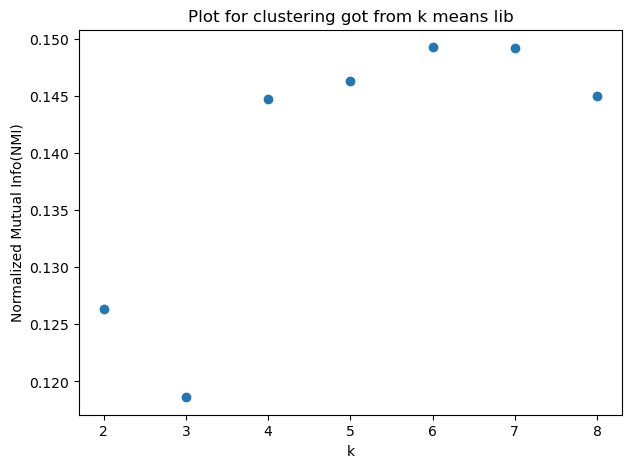

In [21]:
x = [2, 3, 4, 5, 6, 7, 8]
y = nmi

# Creating figure
fig = plt.figure(figsize = (7, 5))
ax = plt.axes()
 
# Creating plot
ax.scatter(x, y)
plt.title("Plot for clustering got from k means lib")
 
ax.set_xlabel('k')
ax.set_ylabel('Normalized Mutual Info(NMI)')
plt.savefig('sklearn-k-vs-nmi.png')

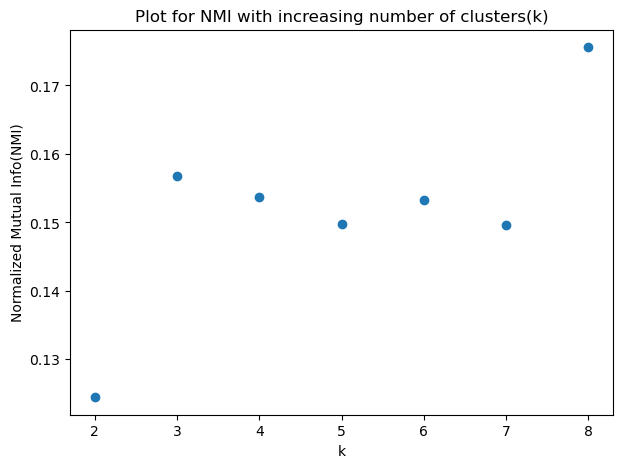

In [22]:
x_n = [2, 3, 4, 5, 6, 7, 8]
y_n = nmi_n

# Creating figure
fig = plt.figure(figsize = (7, 5))
ax = plt.axes()
 
# Creating plot
ax.scatter(x_n, y_n)
plt.title("Plot for NMI with increasing number of clusters(k)")
 
ax.set_xlabel('k')
ax.set_ylabel('Normalized Mutual Info(NMI)')
plt.savefig('k-vs-nmi.png')

In [23]:
max(nmi_n)

0.175588579633748

In [24]:
max_ = float('-inf')
max_i = 0
for i in range(len(nmi_n)):
    if nmi_n[i] > max_:
        max_ = nmi_n[i]
        max_i = i

In [25]:
max_i

6